# Single population *E. coli* model

In this first example, we will build a monoculture, single population dynamic model of *E. coli* and run the dynamic FBA simulation on different environmental conditions.

First, make sure that the notebook kernel activated uses the daphnePy2 conda environment. 

We start by setting the path of the working dir and load the relevant packages.

In [2]:
%load_ext autoreload
%autoreload 2

# Change the absolute path of your daphne folder

DAPHNEPATH='/home/succurro/repositories/gitlab/daphne/'

In [3]:
# Load all the needed modules
import sys
sys.path.append(DAPHNEPATH+'code/python/')
import classModel as cmo
import classReaction as cre
import classMetabolite as cme
import classConsortium as cco
import classPlotter as plotter
import classConvertionFactors as ccf
import cobra
import pandas
from cobra.flux_analysis import parsimonious
import numpy as np
import matplotlib.pyplot as plt
import argparse
import plstyles
import random
import cPickle
import json
import copy
from matplotlib import gridspec


## Overview of the model

The ODE model consists of one "generalistic" *E. coli* population $\text{EC}_{any}$ that can consume both glucose (Gl) and acetate (Ac).

\begin{align*}
\dfrac{d \text{BM}_{\text{EC}_{any}}}{dt} &= v^{\text{EC}_{any}}_\mu\cdot\text{BM}_{\text{EC}_{any}}-\delta\text{BM}_{\text{EC}_{any}},\\
\dfrac{d \text{Gl}}{dt} &= v^{\text{EC}_{any}}_\text{EX_Gl_e}\cdot\text{BM}_{\text{EC}_{any}}+ {\xi_{\text{fed-batch}}}, \\
\dfrac{d \text{Ac}}{dt} &= v^{\text{EC}_{any}}_\text{EX_Ac_e}\cdot\text{BM}_{\text{EC}_{any}}+ {\zeta\cdot H(t-t_x)}\cdot\text{BM}_{\text{EC}_{any}}.
\end{align*}

This ODE model is linked to a SBML model, in our example the [*E.  coli* core model](http://bigg.ucsd.edu/models/e_coli_core), and we have have to define the SBML-dependent names of the reactions that we plan to follow over time.

In order to translate this theoretical model into a DAPHNE model, we need to understand what the different components are. 

### Metabolites (classMetabolite)

The model consists of 3 equations following the temporal variation in the quantity of 3 "dynamic metabolites" DMetabolite or Biomass (which inherits from DMetabolite) objects:

* $\text{BM}_{\text{EC}_{any}}$, the population biomass, which is to be initialized as a classMetabolite.Biomass object
* Gl, glucose, a classMetabolite.DMetabolite object
* Ac, acetate, a classMetabolite.DMetabolite object

For these metabolites we need also initialization values, which depend on the environment/condition.

### Reactions (classReaction)

\begin{align*}
\dfrac{d \text{BM}_{\text{EC}_{any}}}{dt} &= \color{red}{v^{\text{EC}_{any}}_\mu}\cdot\text{BM}_{\text{EC}_{any}}-\color{blue}{\delta}\text{BM}_{\text{EC}_{any}},\\
\dfrac{d \text{Gl}}{dt} &= \color{red}{v^{\text{EC}_{any}}_\text{EX_Gl_e}}\cdot\text{BM}_{\text{EC}_{any}}+ \color{blue}{\xi_{\text{fed-batch}}}, \\
\dfrac{d \text{Ac}}{dt} &= \color{red}{v^{\text{EC}_{any}}_\text{EX_Ac_e}}\cdot\text{BM}_{\text{EC}_{any}}+ \color{blue}{\zeta\cdot H(t-t_x)}\cdot\text{BM}_{\text{EC}_{any}}.
\end{align*}

There are 6 reactions (in a general sense) in the equations, 3 of them linked to flux solutions from the FBA problem (highlighted in red) and 3 that are independent of the FBA solution (highlighted in blue). We need to define a "dynamic reaction" DReaction object only for those reactions that have rates changing over time:

* $v^{\text{EC}_{any}}_\mu$, the biomass flux solution, retrieved from FBA
* $v^{\text{EC}_{any}}_\text{EX_Gl_e}$, the glucose consumption rate, retrieved from FBA
* $v^{\text{EC}_{any}}_\text{EX_Ac_e}$, the acetate consumption/secretion rate, retrieved from FBA
* $\zeta\cdot H(t-t_x)$, a step function for the feeding of acetate at a certain time point, condition dependent

We do not need a DReaction object for:

* $\delta$, the cell death rate, a fixed parameter
* $\xi_{\text{fed-batch}}$, the fed-batch rate for glucose, a fixed parameter condition dependent




## Model construction

### Initialization of parameters, labels etc.

We start initializing the parameters and other elements for the simulations.

In [4]:
## SBML model to load
mpath = DAPHNEPATH+'ecoli/bigg/e_coli_core.xml'

## Biomass function name and reaction names in the SBML model
bmf = 'BIOMASS_Ecoli_core_w_GAM'
rxnnames = {'EX_glc_e':'EX_glc__D_e', 
            'EX_o2_e': 'EX_o2_e',
            'EX_ac_e':'EX_ac_e'}

## General labels
label='diauxic_shift'
ename = 'ecoli core'

### Experimental conditions (from Enjalbert et al. 2015)

We will use as examples the 3 experimental conditions from Enjalbert et al., namely:

1. Batch Growth on 15mM Glucose
2. Batch Growth on 15mM Glucose and feeding of acetate upon glucose exhaustion to maintain a concentration of 4mM Acetate
3. Batch Growth on 15mM Glucose and constant feeding of acetate to maintain a concentration of 32mM Acetate

However, you can also define other environmental conditions.

In [5]:
# Initialize parameters environment and condition dependent to 0
expcond = 'NA'
biomass0 = 0.
glucose0 = 0.0 #mM
acetate0 = 0.0 #mM
ac_thr = 0.0
# Glucose fed-batch paramter
fb=0.
# Acetate feeding paramter
afb=0.
# Time at which glucose is exhausted and acetate feeding starts (Enjalbert et al. 2015 conditions)
t_glc = 0.0

# Approximate convertion valute from OD to gDW measurement
ODtoGDW=0.33
# Biomass dilution rate in chemostat, 1/hr
ch = 0.
# Cell death rate
death_rate = -0.03
# Conditions from Enjalbert et al. 2015
volExt = 0.03
volUn = 'L'
expcondLabels = {'batch_low_Glc': 'grown on 15 mM Glc',
                 'fedbatch_low_Ac': 'grown on 15 mM Glc, fed 4 mM Ac',
                 'fedbatch_high_Ac': 'grown on 15 mM Glc, fed 32 mM Ac'}

# Set flags for the 3 conditions of interest
# Set one condition flag to True
runbatchglc = False
runfedlowacetate = False
runfedhighacetate = True

if runbatchglc:
    print('Simulating Batch Growth on 15mM Glucose as in Enjalbert2015')
    expcond = 'batch_low_Glc'
    biomass0 = 0.0027*0.95
    glucose0 = 15.0 #mM
    acetate0 = 0.0 #mM
    fb = 0.
    afb = 0.
elif runfedlowacetate:
    print('Simulating Batch Growth on 15mM Glucose and constant 4mM Acetate as in Enjalbert2015')
    expcond = 'fedbatch_low_Ac'
    biomass0 = 0.0038*0.95
    glucose0 = 15.0
    acetate0 = 0.0
    afb = 1.0
    ac_thr = 4.0
    t_glc = 3.8
elif runfedhighacetate:
    print('Simulating Batch Growth on 15mM Glucose and constant 32mM Acetate as in Enjalbert2015')
    expcond = 'fedbatch_high_Ac'
    biomass0 = 0.006*0.75
    glucose0 = 15.0
    acetate0 = 32.0
    afb = 1.0
    ac_thr = 32.0
    t_glc = 3.3
else:
    print('Simulating custom conditions')

## Units:
## biomass0 is already gDW
## glucose0 and acetate0 are concentrations (mM)
## dMetabolites are initialized with quantities (mmol)
acetate0 = volExt*acetate0 # mM*L = mmol
glucose0 = volExt*glucose0 # mM*L = mmol

Simulating Batch Growth on 15mM Glucose and constant 32mM Acetate as in Enjalbert2015


### FBA flux constraints

We now define the fixed parameters to constrain the FBA problem. These values are taken from literature and are not changed for the different conditions. For glucose and acetate uptake, they are used to define a Michaelis-Menten kinetics.

In [6]:
## Fixed FBA related parameters
## Uptake Vmax 10 mmol/g/hr (Gosset, 2005)
## Uptake Km 10 muM = 0.01 mM (Gosset, 2005)
vmaxexglc = 10. #mmol/g/hr
vmaxexace = 10. #mmol/g/hr
kmuptake = 0.01 #mM
## Parametrized with Varma 1994
vminoxygen = -11.5
ubexace = 3.0

### DMetabolites

We now initialize 3 dynamic metabolites:

\begin{align*}
\dfrac{d \color{red}{\text{BM}_{\text{EC}_{any}}}}{dt} &= (v^{\text{EC}_{any}}_\mu -\delta )\cdot\color{red}{\text{BM}_{\text{EC}_{any}}},\\
\dfrac{d \color{orange}{\text{Gl}}}{dt} &= v^{\text{EC}_{any}}_\text{EX_Gl_e}\cdot\color{red}{\text{BM}_{\text{EC}_{any}}}+ {\xi_{\text{fed-batch}}}, \\
\dfrac{d \color{blue}{\text{Ac}}}{dt} &= (v^{\text{EC}_{any}}_\text{EX_Ac_e} + {\zeta\cdot H(t-t_x)})\cdot\color{red}{\text{BM}_{\text{EC}_{any}}}.
\end{align*}

The initialization of a DMetabolite object requires the following arguments:

1. The name of the metabolite in the SBML model (if there is a correspondent one).
2. The initial quantity.
3. A boolean, true for internal metabolites.
4. A dictionary of reactions in which the metabolite is involved. The dictionary keys are the reactions' names (which may or may not have a corresponding DReaction object, depending if their rates change over time or not), the dictionary values are lists of tuples. Each tuple corresponds to a multiplication factor. If the reaction is a fixed rate (e.g. $\xi_{\text{fed-batch}}$), the tuple has as 1st element the fed-batch rate, and as 2nd element None. If the reaction is proportional to the biomass (e.g. $\delta\text{BM}_{\text{EC}_{any}}$), the tuple contains the death rate and the biomass DMetabolite name (which will be assigned later on when the model is initialized).
5. Quantity units, optional, deafults to mmol

In [7]:
biomass_EC = cme.Biomass([biomass0], {'growth': [(1, 'biomass_EC')], 'death': [(death_rate, 'biomass_EC')]})
ex_glucose_EC = cme.DMetabolite('glc_D_e', [glucose0], False, {'glucose_exchange': [(1, 'biomass_EC')], 'glucose_fed': [(fb, None)] })
ex_acetate_EC = cme.DMetabolite('ac_e', [acetate0], False, {'acetate_exchange': [(1, 'biomass_EC')], 'acetate_fed': [(afb, 'biomass_EC')]})

### DReactions

We need to initialize DReaction objects for those reactions that will have rates changing over time. Some will be linked to the FBA solution, some won't. The initialization of a DReaction object requires the following arguments:

1. The name of the corresponding SBML reaction if the reaction is linked to the FBA problem, None if not.
2. A KineticLaw object that describes the evolution over time of the reaction rate
3. A boolean, True if the reaction is irreversible

Additional optional arguments can be specified for more specific kinetic laws. For example, the isODE argument is a boolean with value True if the function is a pure ODE function (i.e. not linked to the FBA problem).


In [8]:
acetate_exchange_EC = cre.DReaction(rxnnames['EX_ac_e'], cre.MichaelisMenten1(ex_acetate_EC, 1, vmaxexace, kmuptake, 1, upperBound=ubexace), False)
glucose_exchange_EC = cre.DReaction(rxnnames['EX_glc_e'], cre.MichaelisMenten1(ex_glucose_EC, 1, vmaxexglc, kmuptake, 1, upperBound=15.), False)
growth_EC = cre.DReaction(bmf, cre.FixedBound(0., 1000.))
acetate_fed_EC = cre.DReaction(None, cre.SquareWave(min(9.1, vmaxexace), 20, 1, t_glc), True, isODE=True)
oxygen_exchange_EC = cre.DReaction(rxnnames['EX_o2_e'], cre.FixedBound(vminoxygen, 0), False)

### DynamicModel

We now have to initialize the DynamicModel object. It needs the following arguments:

1. A dictionary of the DReaction objects constituting the model, the keys of the dictionary must be consistent with the keys previously used to initialize the DMetabolite objects.
2. A dictionary of the DMetabolite objects constituting the model, the keys of the dictionary must be consistent with the keys previously used to initialize the DMetabolite objects.
3. The path to the SBML model.
4. The volume of the environment.
5. The units of the volume.
6. The solver to be used to solve the FBA problem.
7. A name to be used to save the model.
8. The path where to store the simulation output (pickle file).


In [9]:
## Define the dictionary of DReactions
dyRxn_EC = {'glucose_exchange': glucose_exchange_EC, 
            'acetate_exchange': acetate_exchange_EC,
            'acetate_fed': acetate_fed_EC,
            'oxygen_exchange': oxygen_exchange_EC,
            'growth': growth_EC}
## Define the dictionary of DMetabolites
dyMet_EC = {'biomass_EC': biomass_EC,
            'ex_glucose': ex_glucose_EC,
            'ex_acetate': ex_acetate_EC}

## Initialize the model
exitname = '%s-%s-%s' % (ename, expcond, label) 
model_EC = cmo.DynamicModel(dyRxn_EC, dyMet_EC, mpath, volExt, volUn, 'optlang-glpk', exitname+'_EC', savePath='./')

## Load the model 
model_EC.loadSBMLModel()
## Set the objective function of the FBA problem
model_EC.resetObjective()
model_EC.setObjective(growth_EC.modName, 1.)
## Make sure no extra carbon sources are available in the environment
model_EC.constrainSources(element='C', count=0, uptakeOff=True)
## Initialize the metabolite concentrations
model_EC.initializeConcentrations()
## Use the pFBA method to solve the FBA problem
model_EC.setParsimoniousFBA(True)
## Continue the simulation as a pure ODE system once the FBA problem becomes infeasible
model_EC.setQuitOnFBAError(False)
## Set a threshold to enter stationary phase
## Not relevant here (set to a negative value)
model_EC.setMinimalMaintenance(growth_EC.modName, -0.15)
## Set a threshold on the difference between constraints at 
## different time points to decide whether to restart FBA or not
## Relevant only in the case the environment is abruptly changed 
model_EC.setBoundsThreshold(0.8*vmaxexglc)
## Set the ATPM constraints directly in the cobra model
model_EC.cbModel.reactions.get_by_id('ATPM').upper_bound = 8.39
model_EC.cbModel.reactions.get_by_id('ATPM').lower_bound = 8.39

### Run the simulation

We can now run the simulation, using the runDynamicFBA method. It needs as argument:

1. Maximal simulated time (in hours) after which it will exit.
2. Method for the ODE integration.
3. Tuple for the parameters of the ODE integration: (flag for the integration mode, minimal step size, maximal step size, maximum number of steps).
4. Boolean flag, True for verbose output.
5. Boolean flag, True to quit upon an infeasible FBA solution.


In [10]:
## Set simulation parameters
maxtime = 10.5
minstep = 0.0
nsteps = 10000

## Start simulation
model_EC.runDynamicFBA(maxtime, 'vode', (0, minstep, 1., nsteps), False, quitOnFBAError=False)

End of dFBA simulation
	 stopDFBA message:	Reached max time 10.744163
	 stopFBA message:	FBA problem OK



### Plot the output

We can now plot the simulation result, overlaying the data from Enjalbert et al. 2015. For this we load the function defined in the file plotFunctions.py.


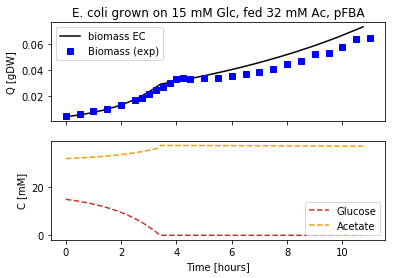

In [11]:
%reload_ext autoreload
%autoreload 2

from plotFunctions import plotEnjalbert2015_growth1EC

plotEnjalbert2015_growth1EC(model_EC, expcond, '-'.join(exitname.split('-')[1:]), DAPHNEPATH)